# Analytics Tasks for New Environment Demo

The following is a tool-agnostic set of tasks commonly required of analyitics organizations.  This list is not exhaustive, but is designed to be a starting point for the evaluation of new tools and processes.  Example code is in Python, but the work being executed should be able to be completed in any language or analytical environment being considered for use in high performing data-centered teams.

In [60]:
# Import tools
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as msno
import wget
import mapclassify
import lineapy
import os

# 1. Acquire Data:
## Extract Transform Load (ETL), DB Query, Download, API Call, Scrape

Note: GREAT geographic shapefile source: 
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

### Download CDC Social Vulnerability County-level shapefile from:

https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html

In [9]:
svi = gpd.read_file(os.getcwd()+'/SVI2020_US_COUNTY')

In [16]:
svi.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRA,MP_OTHERRA,SHAPE_STAr,SHAPE_STLe,geometry
0,01,Alabama,AL,01001,Autauga,01001,"Autauga County, Alabama",594.455838,55639,0,...,0.2,0.0,0.1,2.0,0.7,0.2,0.3,0.150259,2.052888,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,01,Alabama,AL,01003,Baldwin,01003,"Baldwin County, Alabama",1589.835294,218289,0,...,0.2,0.0,0.1,1.9,0.4,0.3,0.2,0.409924,4.278488,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
2,01,Alabama,AL,01005,Barbour,01005,"Barbour County, Alabama",885.007618,25026,0,...,0.3,0.0,0.1,1.3,0.6,0.6,0.4,0.223268,2.569455,"POLYGON ((-85.74803 31.61918, -85.74543 31.618..."
3,01,Alabama,AL,01007,Bibb,01007,"Bibb County, Alabama",622.469288,22374,0,...,0.1,0.0,0.2,0.4,0.3,0.0,0.2,0.156518,1.886874,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
4,01,Alabama,AL,01009,Blount,01009,"Blount County, Alabama",644.890375,57755,0,...,0.1,0.1,0.1,1.8,0.3,0.3,0.4,0.164413,2.391048,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


In [54]:
# rename 'ST_ABBR' and 'STCNTY' columns
svi.rename(columns={'ST_ABBR':'state','STCNTY':'fips'},inplace=True)

### Download the latest JHU CSSE US Covid-19 deaths timeseries data from:

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

In [12]:
filename = wget.download('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')


100% [....................................................] 11424256 / 11424256

In [18]:
covid_deaths = pd.read_csv(os.getcwd()+'/time_series_covid19_deaths_US.csv',dtype={'FIPS':str}) # Note: read FIPS as string to retain leading zeroes
# Rename "FIPS" column
covid_deaths.rename(columns={'FIPS':'fips'},inplace=True)

# 2. Evaluate Data: 
## data taypes (datetime, percentages, leading zeroes, as in FIPS/ZIPS?), missing elements, formatting issues, outliers

# Covid data first:

In [29]:
covid_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Columns: 1117 entries, UID to 1/30/23
dtypes: float64(2), int64(1108), object(7)
memory usage: 28.5+ MB


In [19]:
covid_deaths.head()

,UID,iso2,iso3,code3,fips,Admin2,Province_State,Country_Region,Lat,Long_,...,1/21/23,1/22/23,1/23/23,1/24/23,1/25/23,1/26/23,1/27/23,1/28/23,1/29/23,1/30/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,230,230,230,230,230,230,230,230,230,230
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,722,722,722,722,723,723,723,723,723,723
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,103,103,103,103,103,103,103,103,103,103
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,109,109,109,109,109,109,109,109,109,109
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,261,261,261,261,261,261,261,261,261,261


'fips' column didn't read correctly.  We want a string with 5 characters, leading zeroes, and no decimals

In [23]:
covid_deaths.fips = covid_deaths.fips.str.split('.').str[0].str.zfill(5)

In [24]:
covid_deaths.head()

,UID,iso2,iso3,code3,fips,Admin2,Province_State,Country_Region,Lat,Long_,...,1/21/23,1/22/23,1/23/23,1/24/23,1/25/23,1/26/23,1/27/23,1/28/23,1/29/23,1/30/23
0,84001001,US,USA,840,01001,Autauga,Alabama,US,32.539527,-86.644082,...,230,230,230,230,230,230,230,230,230,230
1,84001003,US,USA,840,01003,Baldwin,Alabama,US,30.727750,-87.722071,...,722,722,722,722,723,723,723,723,723,723
2,84001005,US,USA,840,01005,Barbour,Alabama,US,31.868263,-85.387129,...,103,103,103,103,103,103,103,103,103,103
3,84001007,US,USA,840,01007,Bibb,Alabama,US,32.996421,-87.125115,...,109,109,109,109,109,109,109,109,109,109
4,84001009,US,USA,840,01009,Blount,Alabama,US,33.982109,-86.567906,...,261,261,261,261,261,261,261,261,261,261


<AxesSubplot: >

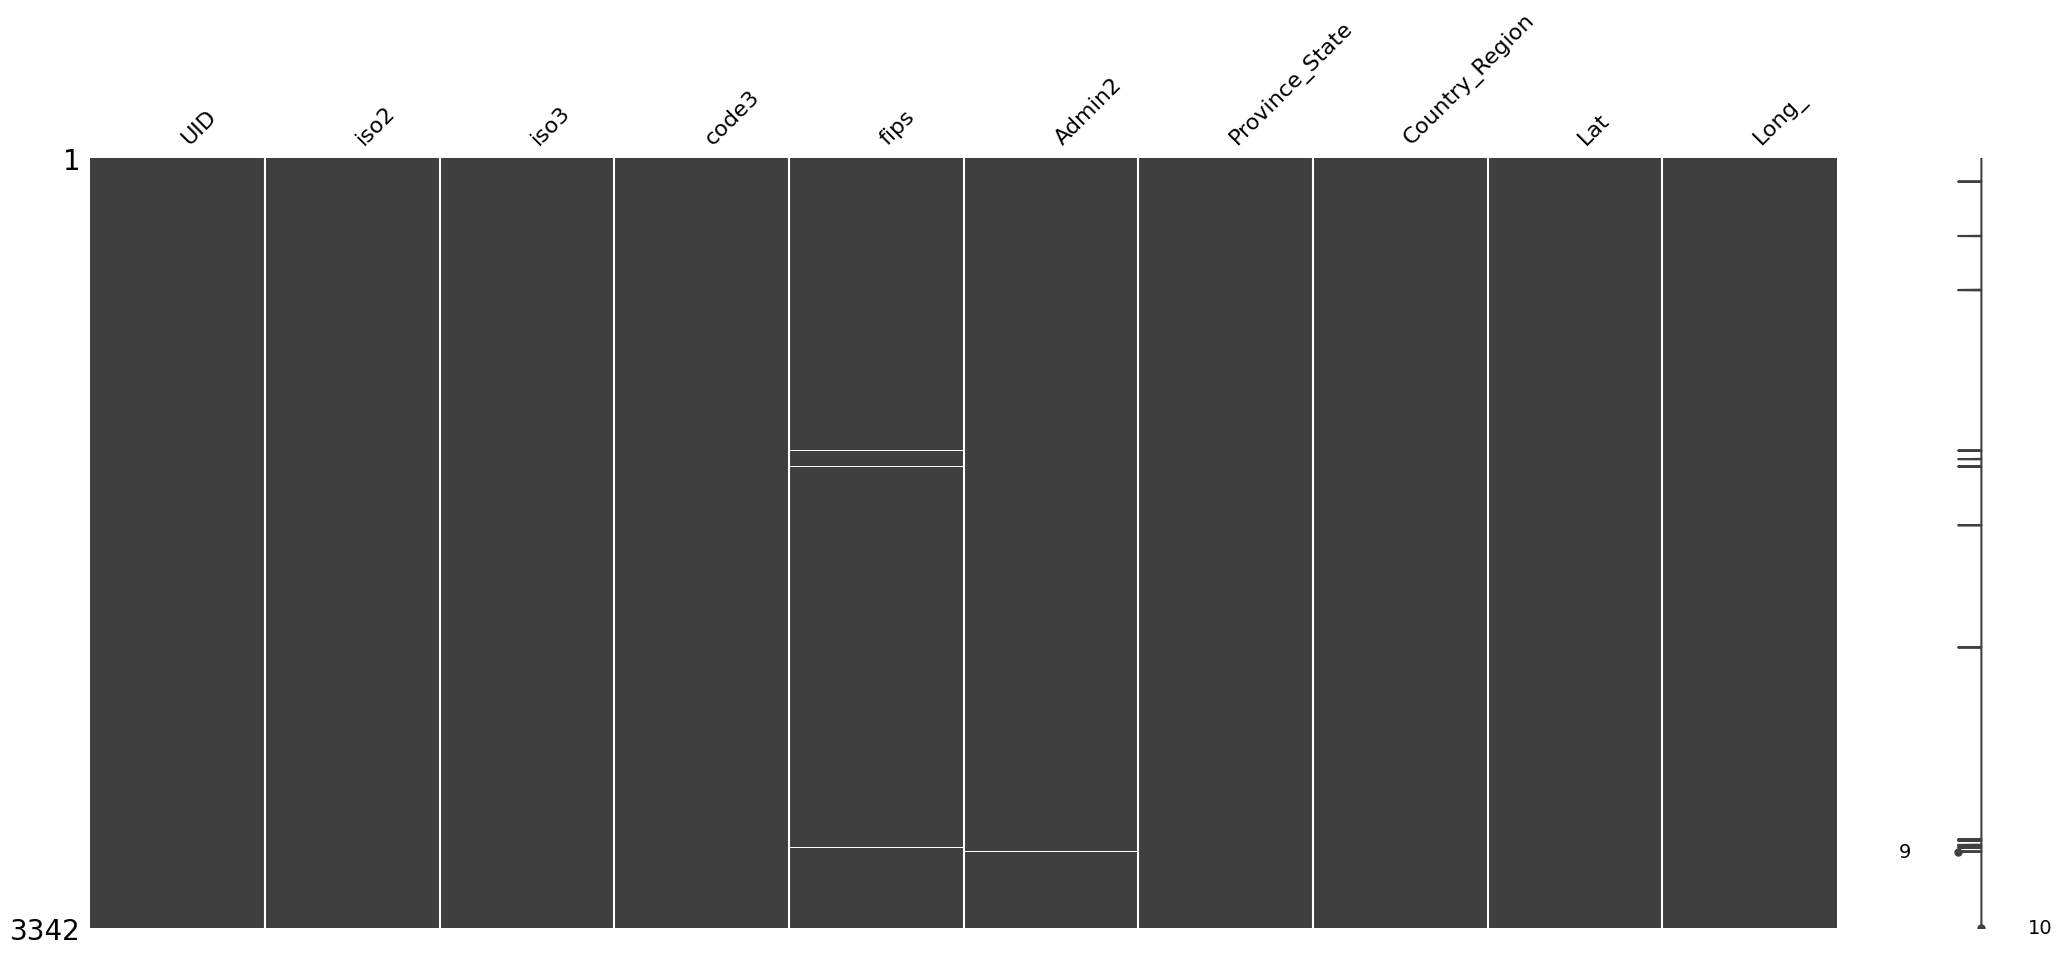

In [35]:
msno.matrix(covid_deaths[covid_deaths.columns[:10].tolist()])

In [36]:
covid_deaths[covid_deaths.fips.isnull()]

,UID,iso2,iso3,code3,fips,Admin2,Province_State,Country_Region,Lat,Long_,...,1/21/23,1/22/23,1/23/23,1/24/23,1/25/23,1/26/23,1/27/23,1/28/23,1/29/23,1/30/23
1269,84070002,US,USA,840,NaN,Dukes and Nantucket,Massachusetts,US,41.406747,-70.687635,...,26,26,26,26,26,26,26,26,26,26
1306,84070005,US,USA,840,NaN,Federal Correctional Institution (FCI),Michigan,US,0.000000,0.000000,...,5,5,5,5,5,5,5,5,5,5
1338,84070004,US,USA,840,NaN,Michigan Department of Corrections (MDOC),Michigan,US,0.000000,0.000000,...,181,181,181,181,181,181,181,181,181,181
1593,84070003,US,USA,840,NaN,Kansas City,Missouri,US,39.099700,-94.578600,...,1326,1326,1326,1331,1331,1331,1331,1331,1331,1331
2956,84070015,US,USA,840,NaN,Bear River,Utah,US,41.521068,-113.083282,...,270,270,270,270,270,271,271,271,271,271
2961,84070016,US,USA,840,NaN,Central Utah,Utah,US,39.372319,-111.575868,...,178,178,178,178,178,179,179,179,179,179
2980,84070017,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,...,96,96,96,96,96,98,98,98,98,98
2981,84070018,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,...,704,704,704,704,704,705,705,705,705,705
2984,84070019,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,...,121,121,121,121,121,121,121,121,121,121
2992,84070020,US,USA,840,NaN,Weber-Morgan,Utah,US,41.271160,-111.914512,...,498,498,498,498,498,499,499,499,499,499


## Note: We'll have to annotate this later

How many total deaths in the US are included in the data?
Let's look at the most recent day's column and sum it

In [44]:
# Thousands separator: f'{value:,}'  
f'{covid_deaths[covid_deaths.columns[-1]].sum():,}'

'1,107,855'

This checks with the JHU covid dashboard:
https://coronavirus.jhu.edu/us-map

![alt text](images/jhu_dash_check.png)

In [49]:
len(covid_deaths.fips.unique())

3333

# And then SVI data:

In [47]:
svi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Columns: 161 entries, ST to geometry
dtypes: float64(77), geometry(1), int64(76), object(7)
memory usage: 3.9+ MB


<AxesSubplot: >

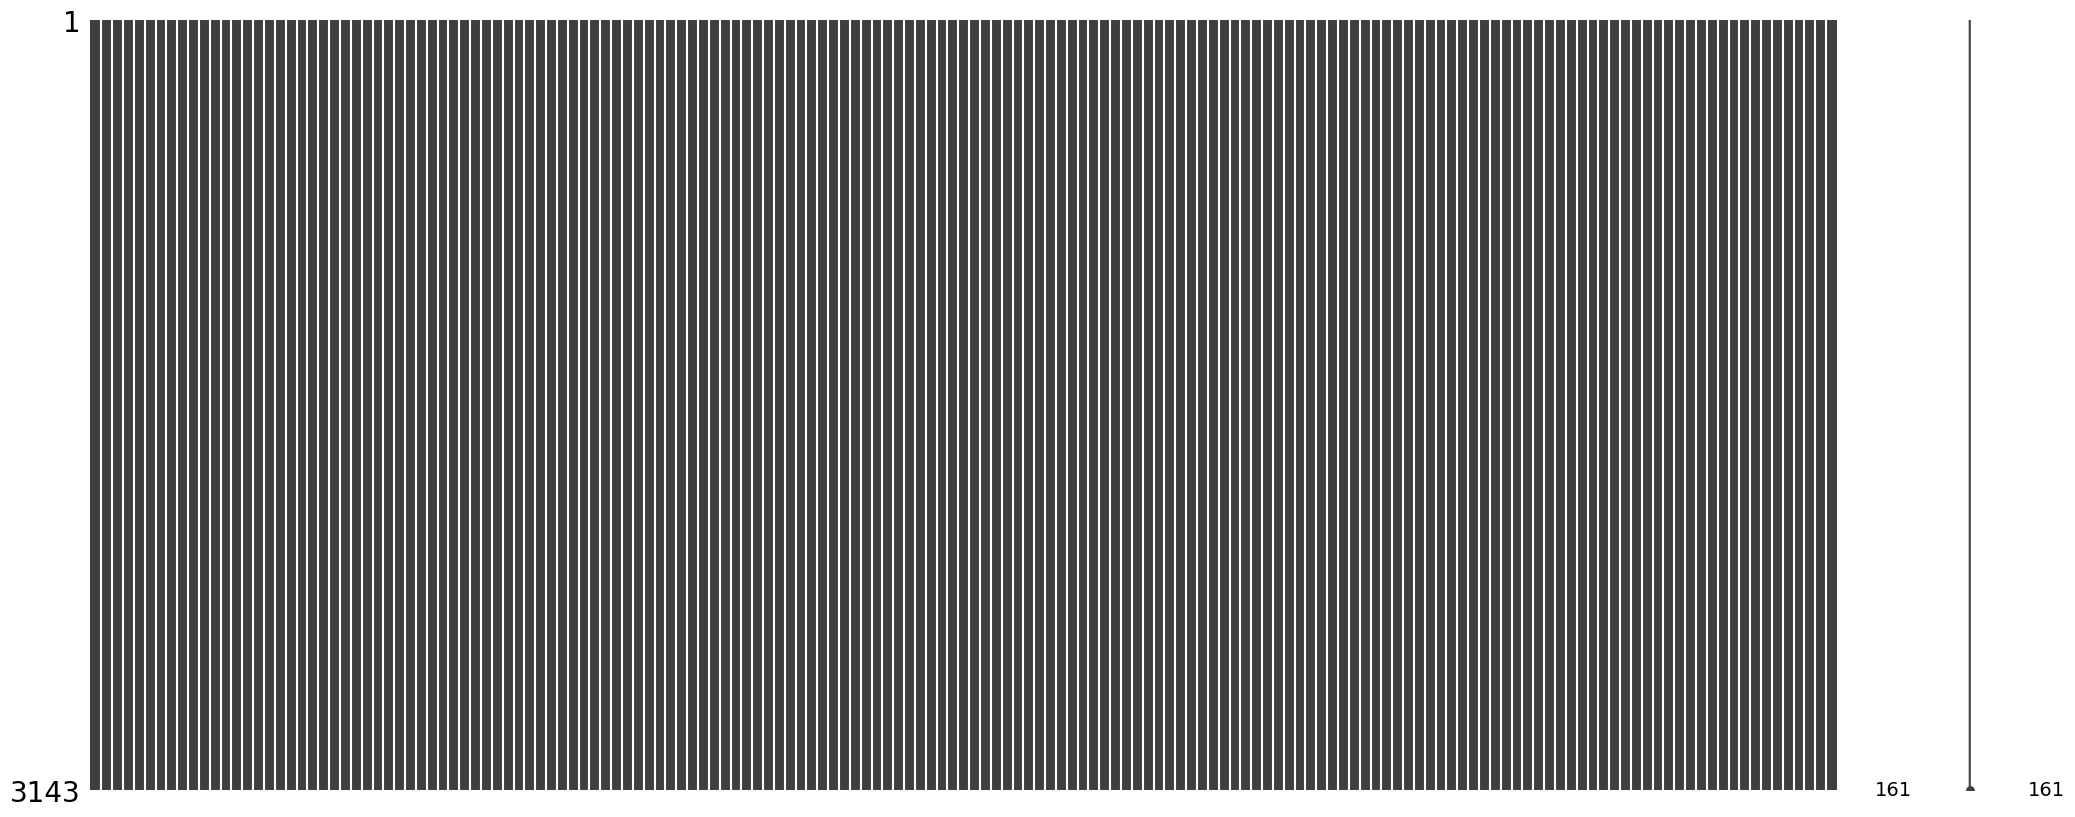

In [48]:
msno.matrix(svi)

<AxesSubplot: >

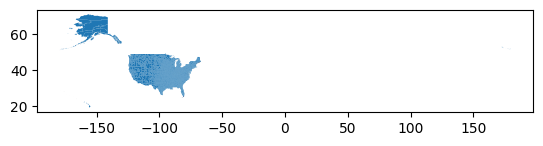

In [46]:
svi.plot()

### Where are the FIPS codes that are in the covid_death frame but not the SVI frame?


In [57]:
covid_deaths[~covid_deaths.fips.isin(svi.fips.unique())][:50]

,UID,iso2,iso3,code3,fips,Admin2,Province_State,Country_Region,Lat,Long_,...,1/21/23,1/22/23,1/23/23,1/24/23,1/25/23,1/26/23,1/27/23,1/28/23,1/29/23,1/30/23
52,84080001,US,USA,840,80001,Out of AL,Alabama,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
64,84090001,US,USA,840,90001,Unassigned,Alabama,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
91,84080002,US,USA,840,80002,Out of AK,Alaska,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
97,84090002,US,USA,840,90002,Unassigned,Alaska,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
98,84002261,US,USA,840,02261,Valdez-Cordova,Alaska,US,61.475028,-144.712680,...,0,0,0,0,0,0,0,0,0,0
102,16,AS,ASM,16,00060,NaN,American Samoa,US,-14.271000,-170.132000,...,34,34,34,34,34,34,34,34,34,34
113,84080004,US,USA,840,80004,Out of AZ,Arizona,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
117,84090004,US,USA,840,90004,Unassigned,Arizona,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
172,84080005,US,USA,840,80005,Out of AR,Arkansas,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
190,84090005,US,USA,840,90005,Unassigned,Arkansas,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


How many deaths were assigned to these non-geography areas?

In [59]:
f'{covid_deaths[~covid_deaths.fips.isin(svi.fips.unique())][covid_deaths.columns[-1]].sum():,}'

'21,428'

# 3. Clean, Shape, Prune, Join Data

# 4. Exploratory Data Analysis

## Visualization: 

Histogram

Scatter plot

Line plot

Bar plot

Horizontal bar plot

Box plot

Choropleth

Sankey diagram

Radar plot

Interactive Choropleth

## Statistical Analysis

Correlation

Linear Regression

Logistic Regression

Supervised Machine Learning

Unsupervised Machine Learning

# 5. Explanatory Data Visualization

Plots, Color Palletes, Annotations, Titles, Subtitles, Legends, Customization & Report Integration

# 6. Geospatial Analysis

autocorrelation, isochrones, geocoding, spatial joins, projections & CRS, 

# 7. Predictive Analytics

Importing and managing timeseries data

model design and feature selection

evaluation of statistical significance & predictive power

explanability to non-stats audiences